In [1]:
import os
import json
import time
import scipy.io as sio
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tensorboardX import SummaryWriter
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import h5py
import matplotlib.pyplot as plt
from matplotlib import animation

from IPython.core.debugger import set_trace

In [2]:
pwd

'/data/TDDIP'

In [ ]:
seq = seq[:,:,spiralsToDelete:] # Removing the first 100 data frame
Nc=np.shape(seq)[1] # 8 number of coils
Nvec=np.shape(seq)[0] # 2496 radial sampling number (virtual k-space)
Nfr = np.shape(seq)[-1] # 2600 number of frames
img_size= 256 # 256       

denc=sio.loadmat(fname)['W'] # (512, 1600)
denc=denc[:,0] # all are same, so just take one.
real_radial = np.transpose(seq,(2,1,0))[...,np.newaxis]
real_radial_ri = np.concatenate((np.real(real_radial),np.imag(real_radial)),axis=3) # real and imaginary

real_radial_ri*=np.tile(denc.astype(np.float32).reshape(1,1,-1,1),[Nc,Nfr,1,2])
real_radial_ri_ts=np_to_torch(real_radial_ri).to(self.dev).detach()

# 111.246 degree - golden angle | 23.63 degree - tiny golden angle
rawang=sio.loadmat(fname)['K'] # (512, 1600, 1, 2)
ang_np=np.squeeze(rawang[:,:,:,0]+1j*rawang[:,:,:,1]).astype(np.complex64)
ang_np=ang_np[:,200:] # (512, 1400)
set_ang=np.zeros((Nfr,Nvec,2))
for idx_fr in range(Nfr):
    set_ang[idx_fr,:,0]=np.real(ang_np[:,idx_fr])*2.*np.pi
    set_ang[idx_fr,:,1]=np.imag(ang_np[:,idx_fr])*2.*np.pi        

# Just for visualization: naive inverse Fourier of undersampled data
# real_radial_ri # inp: (20, 1400, 512, 2), removed batch dimension
print('... calculating nufft for full spoke: gold standard')
inp = real_radial_ri_ts[0,...]
mynufft_test = Mypnufft_grasp_test(img_size,set_ang.reshape((-1,2)),inp.shape[1],Nvec,Nc,coil,denc)
real_radial_img_ri=mynufft_test.backward(inp.reshape((-1,2)))
real_radial_img = (real_radial_img_ri[:,:,0]**2+real_radial_img_ri[:,:,1]**2)**.5 
real_radial_img -= real_radial_img.min()
real_radial_img /= real_radial_img.max()

In [3]:
spiralsToDelete=100;
ninterleavesPerFrame=5;
N = 256;
nChannelsToChoose=8;
SHRINK_FACTOR = 1.3;
nBasis = 20;
lambdaSmoothness = 0.05;
NsamplesToKeep=600;
sigma=[4.5];
lam=[0.1];
eig_csm=0.01;

In [4]:
# !pip install mat73

In [5]:
import mat73

In [6]:
fname = './series11_2.mat'
arrays = mat73.loadmat(fname)
kdata = np.squeeze(arrays['kdata']).astype(np.complex64) # numpy array (2600, 8, 2496), complex128, kt-space data
ktraj = np.squeeze(arrays['k']) # numpy array (2496, 2600), k-trajectory

In [7]:
kdata.shape

(2496, 8, 2600)

In [16]:
ktraj.dtype

dtype('complex128')

In [39]:
denc.reshape(1,1,-1,1).shape

(1, 1, 10000, 1)

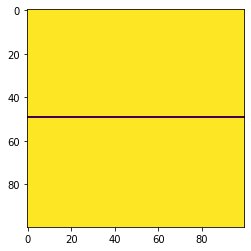

In [43]:
denc = np.ones((100,100))
denc[49,:] = 0
plt.imshow(denc)
plt.savefig('tmp.png')

In [44]:
fname = 'series11_manifold.mat'
arrays = mat73.loadmat(fname)
coil  = arrays['csm'].astype(np.complex64) # numpy array (256, 256, 2)

In [51]:
np.abs(coil).min()

0.00064314273

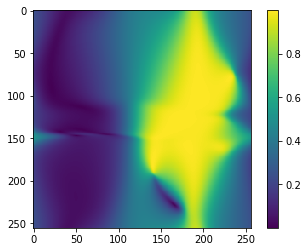

In [49]:
plt.imshow(np.abs(coil[:,:,0]))
plt.colorbar()

In [65]:
5*np.random.randint(0, 2)

0

In [59]:
# ========================================
# -----------Preprocessing Data-----------
# ========================================
nFreqEncoding,nCh,numberSpirals=kdata.shape
numFrames=int(np.floor((numberSpirals-spiralsToDelete)/ninterleavesPerFrame))
kdata = kdata[:,:,spiralsToDelete:] # Removing the first 100 data frame
ktraj = ktraj[:,spiralsToDelete:];
kdata = np.transpose(kdata,(0,2,1));
kdata = np.reshape(kdata,(nFreqEncoding,ninterleavesPerFrame,numFrames,nChannelsToChoose))
ktraj = np.reshape(ktraj,(nFreqEncoding,ninterleavesPerFrame,numFrames))

ValueError: too many values to unpack (expected 3)

In [13]:
numFrames

500

In [12]:
# ========================================
# ----------Scaling trajectory------------
# ========================================
ktraj =  SHRINK_FACTOR*ktraj


In [14]:
ktraj.dtype

dtype('complex128')

In [15]:
ktraj.shape

(2496, 5, 500)

In [ ]:
ktraj

In [ ]:
# ==============================================================
# Compute coil compresession and Compute the coil sensitivity map
# ============================================================== 
kdata=np.reshape(kdata,(nFreqEncoding*ninterleavesPerFrame*numFrames,nChannelsToChoose));
[vkdata] = combine_coils(kdata,0.75);
nChannelsToChoose=size(vkdata,2);
kdata=reshape(vkdata,[nFreqEncoding,ninterleavesPerFrame,numFramesToKeep,nChannelsToChoose]);
[coilImages] = coil_sens_map_NUFFT(kdata,ktraj_scaled,N,useGPU); % 340 x 340 x 2
csm=giveEspiritMaps(reshape(coilImages,[size(coilImages,1), size(coilImages,2), nChannelsToChoose]),eig_csm);
ktraj_scaled=reshape(ktraj_scaled,[nFreqEncoding,ninterleavesPerFrame,numFramesToKeep]); %2496 x 5 x 500
kdata=reshape(kdata,[nFreqEncoding,ninterleavesPerFrame,numFramesToKeep,nChannelsToChoose]); %2496 x 5 x 500 x 2
clear vkdata;

In [ ]:
# ==============================================================
# Compute the weight matrix
# ============================================================= 
kdata_com = reshape(kdata(1:NsamplesToKeep,:,:,:),[NsamplesToKeep,ninterleavesPerFrame,numFramesToKeep,nChannelsToChoose]);
ktraj_com = reshape(ktraj_scaled(1:NsamplesToKeep,:,:,:),[NsamplesToKeep,ninterleavesPerFrame,numFramesToKeep]);
N1 = 64;
csm_lowRes = giveEspiritMapsSmall(coilImages,N1,N1);
ktraj_com = reshape(ktraj_com/N1,[size(ktraj_com,1),size(ktraj_com,2),numFramesToKeep]);
kdata_com = reshape(kdata_com, [size(kdata_com,1),size(ktraj_com,2),numFramesToKeep,nChannelsToChoose]);
FT_LR= NUFFT(ktraj_com,1,0,0,[N1,N1]);
tic;lowResRecons = l2Recont(kdata_com,FT_LR,csm_lowRes,0.1,N1);toc
lowResRecons=reshape(lowResRecons,[N1*N1,numFramesToKeep]);
[~,~,L]=estimateLapKernelLR(lowResRecons,sigma,lam);
[ tmp, L] = iterative_est_laplacian(L,FT_LR,kdata_com,csm_lowRes, N1,sigma, lam);
[~,Sbasis,V]=svd(L);
V=V(:,end-nBasis+1:end);
Sbasis=Sbasis(end-nBasis+1:end,end-nBasis+1:end);